In [35]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SKLEARN
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [36]:
## PEGANDO DADOS DO CHAGALL (DADOS NO GERAL FICARAM NO ARQUIVO catalogo_das_artes_artworks_lots.csv)
lots = pd.read_csv('../temporary-files/catalogo_das_artes_artworks_info.csv')
lots.columns

Index(['Data da Pesquisa', 'Década', 'Técnica', 'Error', 'Descrição', 'Século',
       'Fonte de Pesquisa', 'Tipo', 'img_url', 'url', 'Título', 'Ano',
       'Artista', 'artist_link', 'Avaliação', 'Dimensão'],
      dtype='object')

In [37]:
## FIX COLUMNS

# DIMENSIONS (Width and Height)
lots['Width'] = lots['Dimensão'].str.extract(r'(.*?) x')
lots['Width'] = lots['Width'].str.replace(' cm', '').str.replace(',', '.').astype(float)
lots['Height'] = lots['Dimensão'].str.extract(r'x (.*) cm')
lots['Height'] = lots['Height'].str.replace(' cm', '').str.replace(',', '.').astype(float)

# PRICES (BRL and USD)
lots['Price_BRL'] = lots['Avaliação'].str.extract(r'R\$ (.*?) \|')
lots['Price_BRL'] = lots['Price_BRL'].str.replace('.', '').str.replace(',', '').astype(float) / 100
lots['Price_USD'] = lots['Avaliação'].str.extract(r'USD (.*)$')
lots['Price_USD'] = lots['Price_USD'].str.replace('.', '').str.replace(',', '').astype(float) / 100

# LOT SOLD
# Sold is True if Avaliação column contains 'Valor de venda em leilão:'
lots['Sold'] = lots['Avaliação'].str.contains('Valor de venda em leilão:')

# YEAR OF SALE (From 'Data da Pesquisa' column)
lots['Year of sale'] = lots['Data da Pesquisa'].str.extract(r'(\d{4})')

In [38]:
## DROP ROWS

# ERROR
lots = lots[lots['Error'] == 'False']

# PRICE = 0
lots = lots[lots['Price_BRL'] > 0]

# REMOVE DUPLICATES
lots = lots.drop_duplicates(subset=['url'])

# RESET INDEX
print('Remaining lots: ', len(lots))
lots = lots.reset_index(drop=True)

Remaining lots:  65


In [39]:
## SELECT AND TRANSLATE COLUMNS
lots = lots[['Artista', 'Técnica', 'Ano', 'Tipo',
             'Width', 'Height', 'Year of sale', 'Price_BRL', 'img_url', 'url', 'Sold']]

## translate all columns to english
lots = lots.rename(columns={'Artista': 'Artist', 'Técnica': 'Technique', 'Ano': 'Year',
                            'Tipo': 'Type', 'Width': 'Width (cm)', 'Height': 'Height (cm)',
                            'Year of sale': 'Year of sale', 'Price_BRL': 'Price (BRL)'})

In [40]:
# 10 ARTISTS WITH MORE LOTS
print(lots['Artist'].value_counts().head(10))

Artist
Marc Chagall    65
Name: count, dtype: int64


In [41]:
## ARTISTS DATAFRAMES

artists = lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

In [79]:
artist_name = 'Marc Chagall'

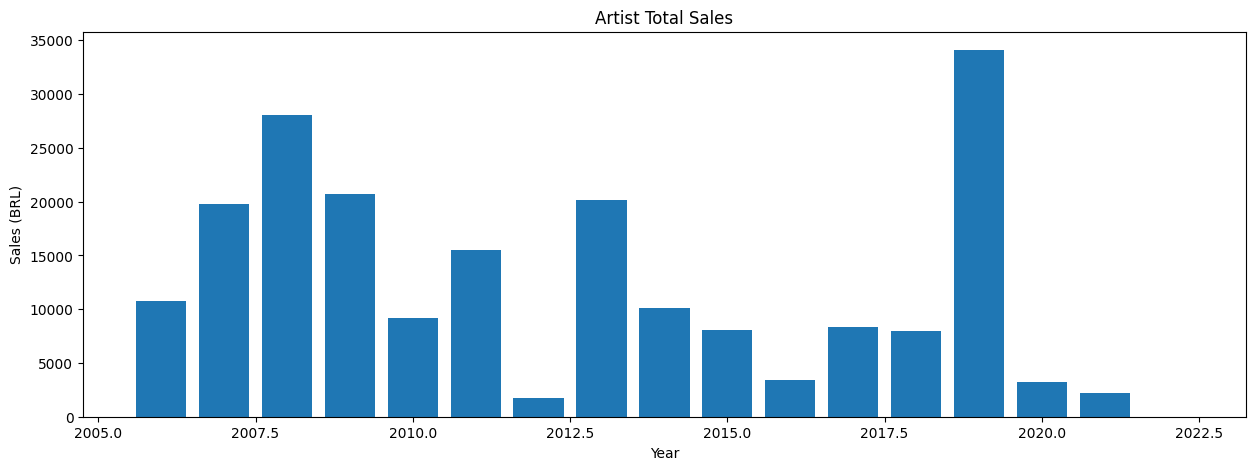

In [81]:
## ARTIST TOTAL SALES
# Based on methodology by ArtPrice at https://www.artprice.com/indicator/howto

artist_total_sales = artists_dataframes[artist_name].drop(['Artist', 'Technique', 'Type'], axis=1)
artist_total_sales = artist_total_sales.groupby('Year of sale').sum()

artist_total_sales = artist_total_sales['Price (BRL)'].round(1)
artist_total_sales.sort_index(ascending=True, inplace=True)
# index of artist_total_sales to int
artist_total_sales.index = artist_total_sales.index.astype(int)
# redefine index as 1997 to 2010 filling missing values with 0
year_start = artist_total_sales.index[0]
year_end = artist_total_sales.index[-1]
artist_total_sales = artist_total_sales.reindex(range(year_start, year_end), fill_value=0)

# plot artist index as column chart
plt.figure(figsize=(15, 5))
plt.title('Artist Total Sales')
plt.ylabel('Sales (BRL)')
plt.xlabel('Year')
plt.bar(artist_total_sales.index, artist_total_sales)
plt.show()

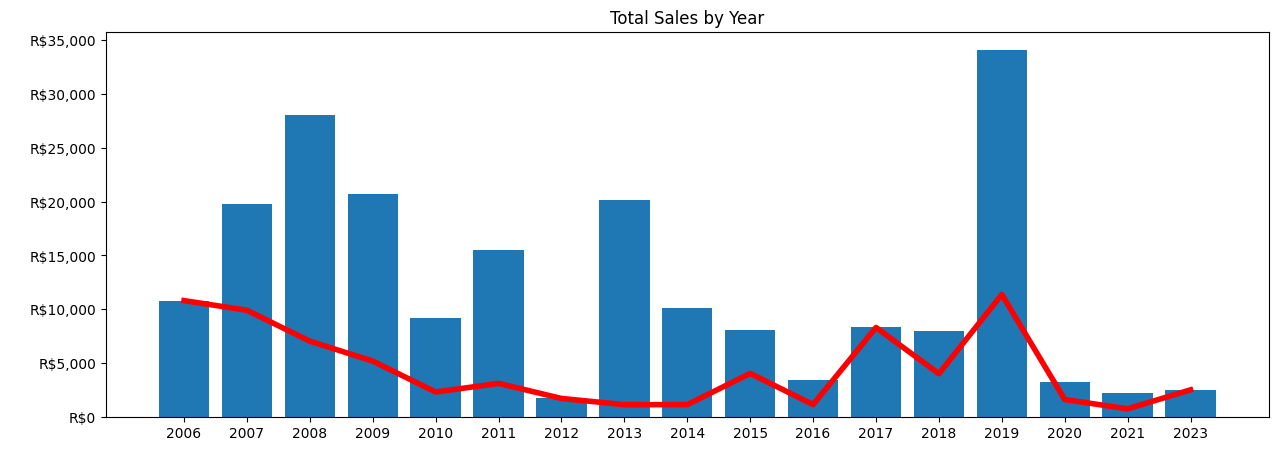

In [ ]:
# plot chart of price_brl by year
sales = pd.DataFrame(lots.groupby('Year of sale')['Price (BRL)'].sum())

sales['Total Sales'] = lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = lots.groupby('Year of sale')['Price (BRL)'].mean()

# plot total sales as bar, mean price as line
plt.figure(figsize=(15, 5))
plt.title('Total Sales by Year')
plt.ylabel('Sales (BRL)', color='white')
# format y axis as currency
plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

plt.xlabel('Year', color='white')

plt.bar(sales.index, sales['Total Sales'])
plt.plot(sales.index, sales['Mean Price'], color='red', linewidth=4)
plt.show()

In [ ]:
## FIT SIZE-PRICE MODELS

lots_to_model = lots.dropna().drop(['Type', 'img_url', 'url'], axis=1)

X = lots_to_model.drop(['Price (BRL)'], axis=1)
y = lots_to_model['Price (BRL)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Technique'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Technique'], drop_first=True)

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# function that fits all models and put metrics into a dataframe
# the function returns the dataframe and a dictionary with the models
def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Random Forest': RandomForestRegressor(),
              'Decision Tree': DecisionTreeRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Random Forest', 'Decision Tree', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

,Linear Regression,Random Forest,Decision Tree,Gradient Boosting
R2,-16.637047,-0.184105,-0.246464,-0.090780
RMSE,41609.217093,10781.314258,11061.560695,10347.734524
MAE,32197.452895,7657.750000,7612.500000,7184.398310


In [ ]:
## SAVE LOCALLY MODEL AND X_TEST

# # save rf model to models
# rf_model = models['Random Forest']
# # save as pkl
# import pickle
# with open('./models/catalogo_rf_model.pkl', 'wb') as file:
#     pickle.dump(rf_model, file)

# # save X_test as csv
# X_test.to_csv('./models/catalogo_X_test.csv', index=False)


In [ ]:
# get only artworks that contain 'lito' or 'Lito' in Technique column
lithographs = lots[lots['Technique'].str.contains('lito|Lito')]
lithographs = lithographs.drop(['Year', 'Artist', 'Technique', 'Type', 'img_url'], axis=1)

lithographs['Price (BRL / m²)'] = lithographs['Price (BRL)'] / (lithographs['Width (cm)'] * lithographs['Height (cm)'])

# sort by year of sale
print('Litogragias de Marc Chagall vendidas em leilão')
lithographs = lithographs.sort_values('Year of sale', ascending=True)
# year of sale as index
lithographs = lithographs.set_index('Year of sale')
lithographs

Litogragias de Marc Chagall vendidas em leilão


,Width (cm),Height (cm),Price (BRL),url,Sold,Price (BRL / m²)
Year of sale,,,,,,
2006,65.0,55.0,10800.0,https://www.catalogodasartes.com.br/obra/zczz/,True,3.020979
2009,23.0,29.0,8000.0,https://www.catalogodasartes.com.br/obra/zcAAe/,False,11.994003
2009,32.0,46.0,7000.0,https://www.catalogodasartes.com.br/obra/zAece/,True,4.755435
2010,26.0,35.0,1500.0,https://www.catalogodasartes.com.br/obra/UcccP/,False,1.648352
2010,27.5,38.0,1500.0,https://www.catalogodasartes.com.br/obra/UAeGU/,False,1.435407
2010,58.0,46.0,2200.0,https://www.catalogodasartes.com.br/obra/UUUee/,True,0.824588
2011,28.0,36.0,5000.0,https://www.catalogodasartes.com.br/obra/BUtBP/,True,4.960317
2011,25.0,32.0,1500.0,https://www.catalogodasartes.com.br/obra/teBUt/,True,1.875000
2011,28.0,36.0,5000.0,https://www.catalogodasartes.com.br/obra/BUtte/,False,4.960317


In [ ]:
## MERGE LOTS DF WITH CATALOGO_DAS_ARTES_LOTS.CSV

# merge lots df with catalogo_das_artes_lots.csv
# old_lots = pd.read_csv('./models/catalogo_das_artes_lots.csv')

# # bring 2 dfs together keeping all columns from both
# merged_lots = pd.concat([lots, old_lots], ignore_index=True)
# merged_lots

,Artist,Technique,Year,Type,Width (cm),Height (cm),Year of sale,Price (BRL),img_url,url,Sold
0,Marc Chagall,Litografia,NaN,Pinturas,23.0,29.0,2009,8000.0,https://s3-sa-east-1.amazonaws.com/catalogodas...,https://www.catalogodasartes.com.br/obra/zcAAe/,False
1,Marc Chagall,Gravura,NaN,Pinturas,27.0,19.0,2009,3200.0,https://s3-sa-east-1.amazonaws.com/catalogodas...,https://www.catalogodasartes.com.br/obra/zAGtc/,True
2,Marc Chagall,Serigrafia,NaN,Pinturas,26.0,33.0,2014,1800.0,https://s3-sa-east-1.amazonaws.com/catalogodas...,https://www.catalogodasartes.com.br/obra/DzcPcP/,False
3,Marc Chagall,Litografia,NaN,Pinturas,18.0,25.0,2011,2500.0,https://s3-sa-east-1.amazonaws.com/catalogodas...,https://www.catalogodasartes.com.br/obra/tzDeP/,True
4,Marc Chagall,Serigrafia,NaN,Pinturas,28.0,37.0,2019,8500.0,https://catalogodashboard.pencillabs.com.br/ht...,https://www.catalogodasartes.com.br/obra/PGUDPA/,False
...,...,...,...,...,...,...,...,...,...,...,...
1080,Juarez Machado,Pastel sobre papel,2003.0,Pinturas,97.0,69.0,2007,10000.0,NaN,NaN,NaN
1081,Joao Baptista da Costa - João Batista da Costa,Óleo sobre cartão,1915.0,Pinturas,20.0,29.5,1998,13130.0,NaN,NaN,NaN
1082,Reynaldo Fonseca - Reinaldo Fonseca,Desenho,1983.0,Pinturas,17.0,23.0,2007,1300.0,NaN,NaN,NaN
1083,Beatriz Milhazes,Óleo sobre Tela,1984.0,Pinturas,165.0,165.0,2003,17850.0,NaN,NaN,NaN


In [77]:
merged_lots.shape

(1085, 11)